In [1]:
import torch
from data.data import generate_sample
from model.dntm.DynamicNeuralTuringMachine import DynamicNeuralTuringMachine
from model.dntm.DynamicNeuralTuringMachineMemory import DynamicNeuralTuringMachineMemory

from utils.wandb_utils import log_params_norm, log_weights_gradient

In [2]:
import seaborn as sns

In [3]:
from IPython.core.debugger import set_trace

## Data

In [4]:
vocab_chars = set('abcdefghijklmnopqrstuvwxyz0123456789()+*-=<>: ')
vocab_size = len(vocab_chars) + 1
target_vocab_chars = set('0123456789-')
target_vocab_size = len(target_vocab_chars)

token2pos = {t: p for p, t in enumerate(vocab_chars)}
token2pos['\n'] = len(token2pos)
target_token2pos = {t: p for p, t in enumerate(target_vocab_chars)}

In [5]:
pos2token = {p: t for t, p in token2pos.items()}

In [6]:
def make_1hot(char, token2pos, vocab_size):
    onehot_vec = torch.zeros((1, vocab_size))
    onehot_vec[0, token2pos[char]] = 1
    return onehot_vec

In [7]:
def make_tensor(sample, token2pos, vocab_size):
    sample_tensor = []
    for c in sample:
        sample_tensor.append(make_1hot(c, token2pos, vocab_size))
    return torch.concat(sample_tensor).unsqueeze(dim=0)

In [8]:
x, y = generate_sample(length=2, nesting=1)
print(x)
print(y)
exec(x)

print((20 if 84>72 else 12))
20
20


In [9]:
x_t, y_t = make_tensor(x, token2pos, vocab_size), make_tensor(y, token2pos, vocab_size)

In [10]:
assert x_t.size(1) == len(x)
assert y_t.size(1) == len(y)

In [25]:
few_samples = [generate_sample(length=2, nesting=1) for i in range(100)]
few_tensor_samples = [(make_tensor(x, token2pos, vocab_size), make_tensor(y, token2pos, vocab_size))
                      for x, y in few_samples]

In [12]:
def get_sample(few_tensor_samples):
    return few_tensor_samples[torch.randint(len(few_tensor_samples), (1,)).item()]

In [31]:
sorted(few_samples, key=lambda x: (len(x[0]), len(x[1])))

[('print((6-1))', '5'),
 ('y=0\nprint(y)', '0'),
 ('print((35-0))', '35'),
 ('t=67\nprint(t)', '67'),
 ('s=12\nprint(s)', '12'),
 ('v=19\nprint(v)', '19'),
 ('d=39\nprint(d)', '39'),
 ('j=85\nprint(j)', '85'),
 ('e=11\nprint(e)', '11'),
 ('z=73\nprint(z)', '73'),
 ('a=40\nprint(a)', '40'),
 ('p=48\nprint(p)', '48'),
 ('b=53\nprint(b)', '53'),
 ('z=85\nprint(z)', '85'),
 ('q=76\nprint(q)', '76'),
 ('k=97\nprint(k)', '97'),
 ('v=78\nprint(v)', '78'),
 ('d=63\nprint(d)', '63'),
 ('print((7+31))', '38'),
 ('x=33\nprint(x)', '33'),
 ('a=15\nprint(a)', '15'),
 ('print((14*2))', '28'),
 ('e=52\nprint(e)', '52'),
 ('print((72*4))', '288'),
 ('print((9-24))', '-15'),
 ('print((1-60))', '-59'),
 ('print((0-81))', '-81'),
 ('print((7*30))', '210'),
 ('print((47-30))', '17'),
 ('print((84-35))', '49'),
 ('print((76-38))', '38'),
 ('print((31-36))', '-5'),
 ('print((14+20))', '34'),
 ('print((35+49))', '84'),
 ('print((41-21))', '20'),
 ('print((11+18))', '29'),
 ('print((67-72))', '-5'),
 ('print(

In [37]:
equal_len_samples = [[('g=61\nfor i in range(6): g+=48\nprint(g)', '349'), 
                     ('r=62\nfor i in range(5): r+=48\nprint(r)', '302')],
                    [('t=67\nprint(t)', '67'),
                     ('s=12\nprint(s)', '12'),],
                    [('print((54*69))', '3726'),
                     ('print((80*57))', '4560'),],
                    [('a=36\nfor i in range(4): a-=96\nprint(a)', '-348'),
                     ('l=24\nfor i in range(3): l-=74\nprint(l)', '-198')],
                    [('print((6-1))', '5'),
                     ('y=0\nprint(y)', '0')],
                    [('l=84\nfor i in range(0): l+=39\nprint(l)', '84'),
                     ('w=94\nfor i in range(0): w+=93\nprint(w)', '94')],
                    [('l=74\nfor i in range(2): l+=51\nprint(l)', '176'),
                     ('y=49\nfor i in range(7): y+=52\nprint(y)', '413'),],
                    [('print((28 if 77<71 else 42))', '42'),
                     ('print((60 if 19<12 else 19))', '19'),],
                    [('print((61 if 66<15 else 36))', '36'),
                     ('print((21 if 72>50 else 65))', '21'),],
                    [('print((35*82))', '2870'),
                     ('print((69*18))', '1242')]]

In [38]:
batched_samples = torch.concat([make_tensor(x, token2pos, vocab_size) for x, y in equal_len_samples[0]])
batched_targets = torch.concat([make_tensor(y, token2pos, vocab_size) for x, y in equal_len_samples[0]])

In [51]:
equal_len_tensor_samples = [torch.concat([make_tensor(x, token2pos, vocab_size) for x, y in equal_len_batch])
                            for equal_len_batch in equal_len_samples]
equal_len_tensor_targets = [torch.concat([make_tensor(y, token2pos, vocab_size) for x, y in equal_len_batch])
                            for equal_len_batch in equal_len_samples]

In [55]:
def get_batch(equal_len_tensor_samples, equal_len_tensor_targets):
    i = torch.randint(len(equal_len_samples), (1,)).item()
    return (equal_len_tensor_samples[i],
            equal_len_tensor_targets[i])

## Model

In [15]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm_cell = torch.nn.LSTMCell(
            input_size=input_size,
            hidden_size=hidden_size)
        self.W_o = torch.nn.Parameter(torch.rand(output_size, hidden_size))
        self.b_o = torch.nn.Parameter(torch.rand(1))
        self.register_buffer("h_t", torch.zeros(2, hidden_size))
        self.register_buffer("c_t", torch.zeros(2, hidden_size))
    
    def forward(self, x):
        self.h_t, self.c_t = self.lstm_cell(x, (self.h_t, self.c_t))
        return self.h_t @ self.W_o.T  + self.b_o
    
    def detach_states(self):
        self.h_t = self.h_t.detach()
        self.c_t = self.c_t.detach()

In [59]:
def train(model, sample, target, loss, opt):
    opt.zero_grad()
    outputs = []

    for char_pos in range(sample.size(1)):
        output = model(sample[:, char_pos, :].squeeze())
    outputs.append(output)

    for char_pos in range(target.size(1) - 1):
        output = model(target[:, char_pos, :].squeeze())
        outputs.append(output)
    
    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        cumulative_loss += loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1))
    avg_loss = cumulative_loss / len(outputs)

    avg_loss.backward()
    opt.step()

    model.detach_states()
    return avg_loss.item()

In [17]:
def train_dntm(model, sample, target, loss, opt):
    opt.zero_grad()
    outputs = []
    
    model.prepare_for_batch(sample, sample.device)
    for char_pos in range(sample.size(1)):
        output = model(sample[:, char_pos, :].reshape(sample.size(2), 2))
    outputs.append(output)

    for char_pos in range(target.size(1) - 1):
        output = model(target[:, char_pos, :].reshape(sample.size(2), 2))
        outputs.append(output)

    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        cumulative_loss += loss(output.squeeze(), torch.argmax(target[:, char_pos, :].squeeze(), dim=1))
    avg_loss = cumulative_loss / len(outputs)

    avg_loss.backward()
    opt.step()

    return avg_loss.item()

In [67]:
model = LSTM(
    input_size=vocab_size,
    hidden_size=100,
    output_size=vocab_size)

In [71]:
dntm_memory = DynamicNeuralTuringMachineMemory(
        n_locations=100,
        content_size=8,
        address_size=8,
        controller_input_size=vocab_size,
        controller_hidden_state_size=100,
    )

In [72]:
dntm = DynamicNeuralTuringMachine(
    memory=dntm_memory,
    controller_hidden_state_size=100,
    controller_input_size=vocab_size,
    controller_output_size=vocab_size,
)

In [73]:
model = dntm

## Train

In [74]:
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
MAX_ITER = 1000

In [69]:
loss_values = []
for step in range(MAX_ITER):
    batched_samples, batched_targets = get_batch(equal_len_tensor_samples, equal_len_tensor_targets)
    loss_values.append(train(model, batched_samples, batched_targets, loss, opt))

In [75]:
loss_values = []
for step in range(MAX_ITER):
    # x_t, y_t = get_sample(few_tensor_samples)
    batched_samples, batched_targets = get_batch(equal_len_tensor_samples, equal_len_tensor_targets)
    loss_values.append(train_dntm(model, batched_samples, batched_targets, loss, opt))

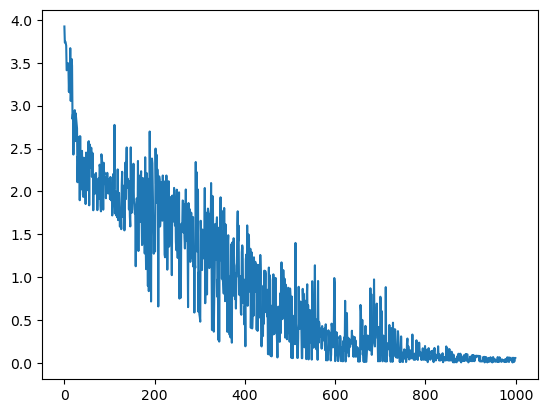

In [76]:
AxesSubplot = sns.lineplot(loss_values)
# _ = AxesSubplot.set(title=f"{x} {y}")

Expected cross-entropy value with random prediction:

In [200]:
torch.log(torch.tensor(vocab_size))

tensor(3.8501)

## Eval

In [201]:
def target_tensors_to_str(y_t):
    idx_outputs = [torch.argmax(o).item() for o in y_t]
    return ''.join([pos2token[idx] for idx in idx_outputs])

In [152]:
# LSTM
sample, target = x_t, y_t

outputs = []
for char_pos in range(sample.size(1)):
    output = model(sample[:, char_pos, :].squeeze())
outputs.append(output)

for char_pos in range(target.size(1) - 1):
    output = model(target[:, char_pos, :].squeeze())
    outputs.append(output)

In [217]:
# D-NTM
sample, target = get_sample(few_tensor_samples)

outputs = []
model.prepare_for_batch(sample, sample.device)
for char_pos in range(sample.size(1)):
    output = model(sample[:, char_pos, :].view(sample.size(2), 1))
outputs.append(output)

for char_pos in range(target.size(1) - 1):
    output = model(target[:, char_pos, :].view(sample.size(2), 1))
    outputs.append(output)

outputs = [o.squeeze() for o in outputs]

In [218]:
target_tensors_to_str(outputs)

'41'

In [219]:
targets = [target[:, i, :].squeeze() for i in range(target.size(1))]
target_tensors_to_str(targets)

'41'